# Recurrent Neural Network

<div style="display: flex; align-items: center;">
    <img src="../imgs/RNN.jpg" alt="Your Image" width="600" style="margin-right: 20px;">
    <div>
        <p>RNN (Recurrent Neural Network) is a deep learning model specifically designed for processing sequential data, such as time series data or natural language texts. Its design enables it to utilize the time dependency in the sequence, where the output of the previous state can become the input of the next state, making it highly effective in processing sequence data.</p>
        <p>The structure of RNN includes a loop unit that can generate outputs and update internal states based on the current input and the state of the previous time step. This cyclic structure enables RNN to capture long-term dependencies in sequences and perform well in handling sequences of various lengths.</p>
        <p></p>
    </div>
</div>

## RNN
Before building the model, let's review the parameters of the new layer:

**nn.RNN** is a simple recurrent neural network (RNN) module implemented in PyTorch. It is used to construct neural network layers with recurrent connections. The common parameters are as follows:

`input_size`: The size of the input features.

`hidden_size`: The number of features in the hidden state.

`num_layers`: (optional) The number of RNN layers. Default is 1.

`nonlinearity`: (optional) The nonlinearity function applied to the input data. Default is 'tanh'.

`bias`: (optional) Whether to include bias terms. Default is True.

`batch_first`: (optional) If True, input and output tensors are provided as (batch, seq, feature). If False, input and output tensors are provided as (seq, batch, feature). Default is False.

`dropout`: (optional) If non-zero, applies dropout to the RNN output. Default is 0.

`bidirectional`: (optional) If True, creates a bidirectional RNN. Default is False.




In [1]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size =  hidden_size
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Train RNN on diy dataset!

This DIY dataset is a simulated temperature time series dataset designed to mimic the variation of temperature over a period of time. The dataset consists of temperature observations spanning 25 years, with one observation per day, totaling 9125 time steps. The temperature data at each time step is generated by a sinusoidal function with added random noise.

Specifically, the temperature data in the dataset exhibits seasonal and diurnal variations. The seasonal variation is modeled by a sinusoidal function with an amplitude of 10 and an offset of 20, representing the range of seasonal temperature variation. The diurnal variation is modeled by the periodic oscillation of the sinusoidal function, reflecting the daily cycle of temperature variation. Additionally, the temperature data at each time step is subject to random noise drawn from a normal distribution, simulating measurement errors or uncertainties in real-world temperature observations.

This dataset can be used to test and validate the performance of time series forecasting models, such as recurrent neural networks (RNNs) or long short-term memory networks (LSTMs). By predicting the temperature trends in this simulated dataset, one can assess the model's ability to fit and generalize to time series data, thereby aiding in the analysis and prediction of actual meteorological data.

**Also,in the following chapters, we will directly call the classes defined based on this train process.**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import random
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime

### Set the Seed

In [3]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Make data

In [4]:
np.random.seed(42)
num_samples = 5000
time_steps = 365 * 25
temperatures = 20 + 10 * np.sin(np.arange(time_steps) * (2 * np.pi / 365)) + np.random.normal(scale=2, size=(time_steps,))
temperatures = np.expand_dims(temperatures, axis=1)

### Normalize data

In [5]:
scaler = MinMaxScaler()
temperatures_scaled = scaler.fit_transform(temperatures)

class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)


seq_length = 30
train_size = int(0.8 * len(temperatures_scaled))

train_data = temperatures_scaled[:train_size]
valid_data = temperatures_scaled[train_size:train_size+int(0.1*len(temperatures_scaled))]
test_data = temperatures_scaled[train_size+int(0.1*len(temperatures_scaled)):]

train_dataset = TemperatureDataset(train_data, seq_length)
valid_dataset = TemperatureDataset(valid_data, seq_length)
test_dataset = TemperatureDataset(test_data, seq_length)

### Load data

In [6]:
BATCH_SIZE = 1
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Load model and Start to train&valid

2024-05-15 19:43:25
Epoch 1 / 10


[Valid]: 100%|██████████████████████████████████| 882/882 [00:01<00:00, 598.65it/s, val_loss=0.0139]


2024-05-15 19:43:56
Epoch 2 / 10


[Valid]: 100%|█████████████████████████████████| 882/882 [00:01<00:00, 599.63it/s, val_loss=0.00564]


2024-05-15 19:44:27
Epoch 3 / 10


[Valid]: 100%|███████████████████████████████████| 882/882 [00:01<00:00, 611.85it/s, val_loss=0.008]


2024-05-15 19:44:59
Epoch 4 / 10


[Valid]: 100%|█████████████████████████████████| 882/882 [00:01<00:00, 604.08it/s, val_loss=0.00752]


2024-05-15 19:45:31
Epoch 5 / 10


[Valid]: 100%|█████████████████████████████████| 882/882 [00:01<00:00, 579.77it/s, val_loss=0.00607]


2024-05-15 19:46:04
Epoch 6 / 10


[Valid]: 100%|██████████████████████████████████| 882/882 [00:01<00:00, 573.46it/s, val_loss=0.0089]


2024-05-15 19:46:36
Epoch 7 / 10


[Valid]: 100%|██████████████████████████████████| 882/882 [00:01<00:00, 576.51it/s, val_loss=0.0066]


2024-05-15 19:47:08
Epoch 8 / 10


[Valid]: 100%|█████████████████████████████████| 882/882 [00:01<00:00, 589.69it/s, val_loss=0.00697]


2024-05-15 19:47:39
Epoch 9 / 10


[Valid]: 100%|█████████████████████████████████| 882/882 [00:01<00:00, 552.09it/s, val_loss=0.00834]


2024-05-15 19:48:11
Epoch 10 / 10


[Valid]: 100%|██████████████████████████████████| 882/882 [00:01<00:00, 551.45it/s, val_loss=0.0688]


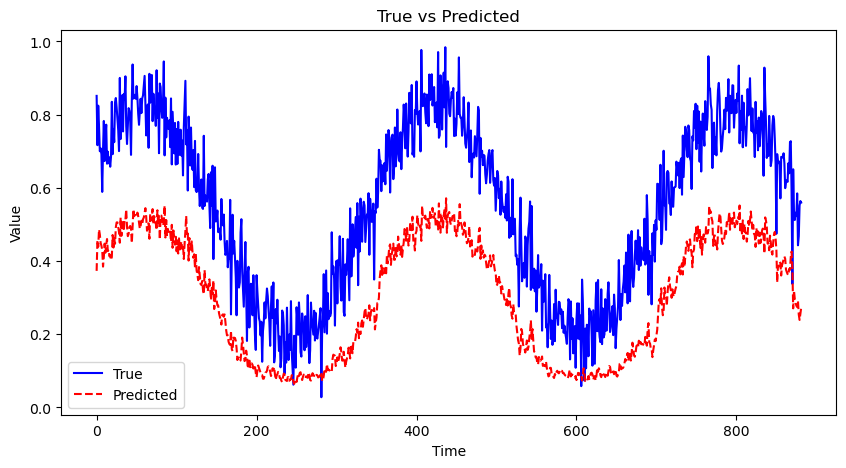

In [8]:
model = RNN(input_size=1, hidden_size=256, output_size=1)
if torch.cuda.is_available():
    model = model.cuda()

loss_fn = nn.MSELoss()
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

total_train_step = 0
total_valid_step = 0
epochs = 10

train_losses = []
val_losses = []


for epoch in range(epochs):
    print('=' * 135)
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print(f"Epoch {epoch + 1} / {epochs}")
    model.train()
    train_bar = tqdm(train_dataloader, desc="[Train]", ncols=90)
    train_losses = []
    for inputs, targets in train_bar:
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
        with autocast(enabled=torch.cuda.is_available()):
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
        train_bar.set_postfix(train_loss=sum(train_losses) / len(train_bar))
    train_bar.close()
    train_losses.append(sum(train_losses) / len(train_bar))
    model.eval()
    predictions = []
    targets_list = []
    valid_loss = 0
    valid_samples = 0
    valid_bar = tqdm(valid_dataloader, desc="[Valid]", ncols=100)
    with torch.no_grad():
        for inputs, targets in valid_bar:
            if torch.cuda.is_available():
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()
            valid_samples += targets.size(0)
            predictions.append(outputs.cpu().numpy())
            targets_list.append(targets.cpu().numpy())
            valid_bar.set_postfix(val_loss=valid_loss / valid_samples)
    valid_bar.close()
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets_list, axis=0)
    val_losses.append(valid_loss / valid_samples)

plt.figure(figsize=(10, 5))
plt.plot(targets, label='True', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted')
plt.legend()
plt.show()

[Valid]: 100%|█████████████████████████████████| 883/883 [00:01<00:00, 462.67it/s, test_loss=0.0597]


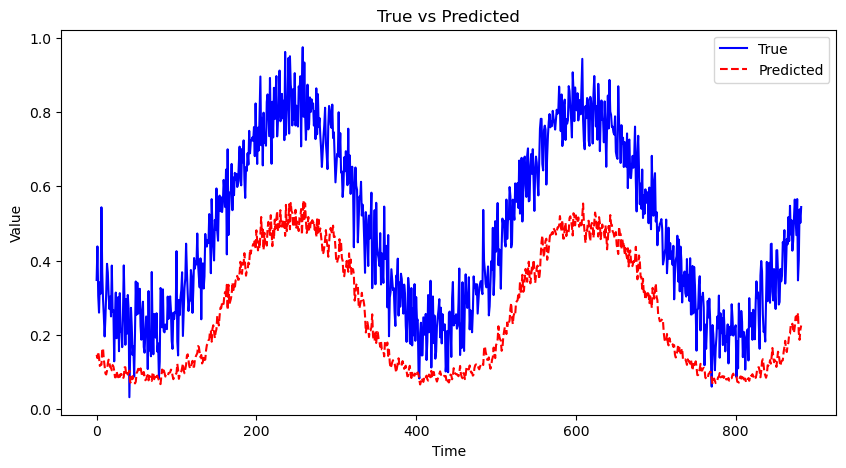

In [9]:
model.eval()
predictions = []
targets_list = []
test_loss = 0
test_samples = 0
test_bar = tqdm(test_dataloader, desc="[Valid]", ncols=100)
with torch.no_grad():
    for inputs, targets in test_bar:
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        test_loss += loss.item()
        test_samples += targets.size(0)
        predictions.append(outputs.cpu().numpy())
        targets_list.append(targets.cpu().numpy())
        test_bar.set_postfix(test_loss=test_loss / test_samples)
test_bar.close()
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets_list, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(targets, label='True', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted')
plt.legend()
plt.show()